# Exploratory Data Analysis

### Basic Setting

In [1]:
import copy
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from forecaster.plot import create_scatter_plot_matrix, create_bar_plot
from dython.nominal import associations
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
import seaborn as sns


warnings.filterwarnings("ignore")
sns.set_theme()
# please check if the font exists in your system
plt.rcParams["font.family"] = "Hiragino Maru Gothic Pro"

# Outline
1. Raw Data Preparation
2. Data Aggregation
3. Individal Feature Visualization
4. Temperoal Effects
5. Spatial Effects


## Raw Data Preparation

### Data loading

In [2]:
users_pdf = pd.read_csv("../data/users.csv").rename({"id": "user_id"}, axis=1)
transaction_pdf = pd.read_csv("../data/transactions.csv", parse_dates=["event_occurrence"])
stores_pdf = pd.read_csv("../data/stores.csv").rename({"id": "store_id"}, axis=1)

print(f"Users -\n columns: {list(users_pdf.columns)};\n shape: {users_pdf.shape}")
print(
    f"Transactions -\n columns: {list(transaction_pdf.columns)};\n shape: {transaction_pdf.shape}"
)
print(f"Stores -\n columns: {list(stores_pdf.columns)};\n shape: {stores_pdf.shape}")


Users -
 columns: ['user_id', 'gender', 'age'];
 shape: (9961, 3)
Transactions -
 columns: ['id', 'user_id', 'store_id', 'event_occurrence', 'amount'];
 shape: (1582260, 5)
Stores -
 columns: ['store_id', 'nam', 'laa', 'category', 'lat', 'lon'];
 shape: (99991, 6)


In [3]:
users_pdf.head()

,user_id,gender,age
0,3cf2d95c-851a-3e66-bd62-36050c1aa8dd,M,30.0
1,a85536f3-1bf8-fbeb-d06e-62e6dc5a2a83,M,55.0
2,355a293c-2c15-d6bd-45ce-cd3c275ee5a9,M,40.0
3,61fb5b45-9bf8-1659-7a0c-b6f85a0f870b,NaN,NaN
4,ff9e16ef-3a0b-9373-567f-fb07cbc96874,M,90.0


### Missing Value Detection
- Conclusion: there are only few missing user records. Can be 996 records found below.
- Note: the missing pattern will be taken care afterwards. Can use imputation techniques or other insensive ML methods.

In [4]:
print(f"Overall User Size: {users_pdf.shape[0]} with {users_pdf.shape[0] - users_pdf.drop_duplicates("user_id").shape[0]} duplicate reords")
print("Missing rate")
display(users_pdf.isnull().sum() / users_pdf.shape[0])


Overall User Size: 9961 with 0 duplicate reords
Missing rate


user_id    0.000000
gender     0.099990
age        0.049995
dtype: float64

In [5]:
# Missing Record
users_pdf[users_pdf.isnull().any(axis=1)]

,user_id,gender,age
3,61fb5b45-9bf8-1659-7a0c-b6f85a0f870b,NaN,NaN
5,921cbaf8-ef1a-c751-17ea-2caaee0d4e92,NaN,49.0
11,4d7af432-1eb9-b387-d876-0cce8470f26d,NaN,NaN
16,9b83a437-28b7-405b-abc2-ded76bd8e65f,NaN,85.0
25,63d45aa3-de2b-5082-9342-365328beae8e,NaN,85.0
...,...,...,...
9910,c76f432c-dc5a-a6c9-d1ab-d865ee9d0e10,NaN,35.0
9921,bc315be3-3269-871d-b008-1c1840fc9f2d,NaN,43.0
9934,5b4720dc-90d3-37af-4365-dedb8522dd90,NaN,88.0
9944,b934718f-2d49-2ca2-41f4-317df5141524,NaN,62.0


In [6]:
print(f"Overall Store Size: {stores_pdf.shape[0]} with {stores_pdf.shape[0] - stores_pdf.drop_duplicates("store_id").shape[0]} duplicate reords")
print("Missing rate")
display(stores_pdf.isnull().sum() / stores_pdf.shape[0])

Overall Store Size: 99991 with 0 duplicate reords
Missing rate


store_id    0.0
nam         0.0
laa         0.0
category    0.0
lat         0.0
lon         0.0
dtype: float64

In [7]:
print(f"Overall Transaction Size: {transaction_pdf.shape[0]} with {transaction_pdf.shape[0] - transaction_pdf.drop_duplicates("id").shape[0]} duplicate reords")
print("Missing rate")
display(transaction_pdf.isnull().sum() / transaction_pdf.shape[0])

Overall Transaction Size: 1582260 with 0 duplicate reords
Missing rate


id                  0.0
user_id             0.0
store_id            0.0
event_occurrence    0.0
amount              0.0
dtype: float64

## Data Aggregation
- Summary: We integrate `user`, `store`, and `transactions` into one comprehensive table, excluding null values in the `user` data. Subsequent analyses will help identify any abnormal patterns.

In [8]:
# Remove users with missing data
clean_users_pdf = users_pdf.dropna()


added_user_to_transactions_pdf = pd.merge(transaction_pdf, clean_users_pdf, on=["user_id"], how="inner")
full_data_pdf = pd.merge(
    added_user_to_transactions_pdf, stores_pdf, on=["store_id"], how="left"
)

full_data_pdf.head(3)


,id,user_id,store_id,event_occurrence,amount,gender,age,nam,laa,category,lat,lon
0,a555eb55-1da4-6087-b5ab-06b35b608002,93098549-3ff0-e579-01c3-df9183278f64,a3c7874b-75df-9cf2-62ab-cf58be5d9e0e,2020-01-01 06:40:43.323987,315,M,88.0,Saitama Ken,Soka Shi,コンビニ,35.830649,139.809781
1,f699b867-e70c-5160-90c8-7dfa32dce0da,35ba9da1-98d0-cbb7-7844-e648601b7208,1d59adf3-94f2-f5f8-46c6-8558c544a3a9,2020-01-01 07:04:25.968615,1646,M,44.0,Gunma Ken,Meiwa Cho,ショッピング,36.216801,139.562541
2,5c3f8abc-f4e6-94fd-7b13-fe0efd4e4591,63cb5ee0-a457-9975-5455-4d76109bc754,c835f09d-ac5b-2005-1959-f452456a746a,2020-01-01 07:06:16.164563,385,M,16.0,Hiroshima Ken,Fukuyama Shi,コンビニ,34.642260,133.257595


In [9]:
print(f"Row size: {full_data_pdf.shape[0]}, Column size: {full_data_pdf.shape[1]}")
display(full_data_pdf.dtypes)


Row size: 1421978, Column size: 12


id                          object
user_id                     object
store_id                    object
event_occurrence    datetime64[ns]
amount                       int64
gender                      object
age                        float64
nam                         object
laa                         object
category                    object
lat                        float64
lon                        float64
dtype: object

### Individual Feature Distribution with Comparison
- Summary: The characteristics of the aggregated data closely resemble those of the original features. Further insights can be gleaned from the following distributions, or we can elucidate the feature importance of the trained model later. In short, no anomalies are observed.

Text(0.5, 1.0, 'Clean Users')

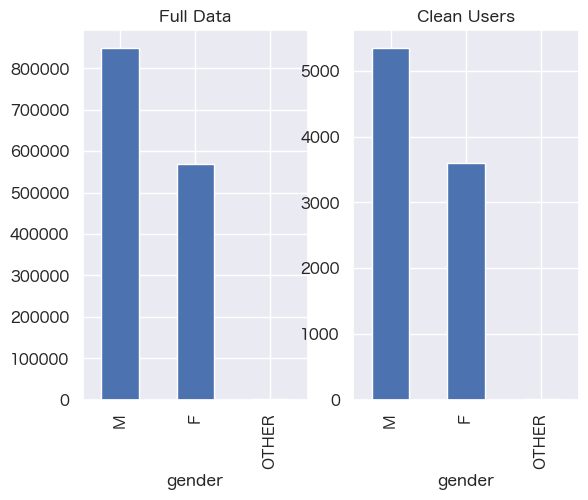

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=2)

full_data_pdf.gender.value_counts().plot(kind='bar', ax=axes[0])
axes[0].set_title('Full Data')

clean_users_pdf.gender.value_counts().plot(kind='bar', ax=axes[1])
axes[1].set_title('Clean Users')


Text(0.5, 1.0, 'Clean Users')

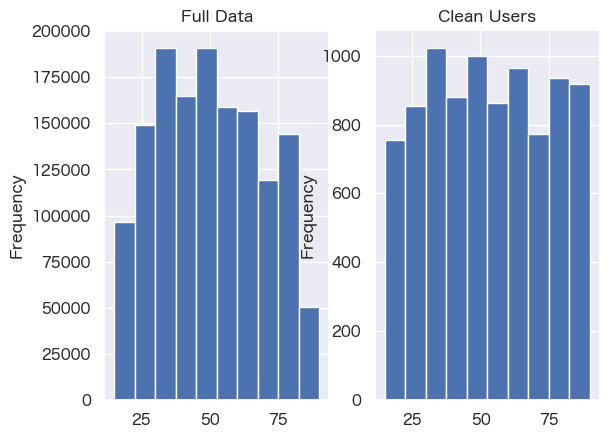

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=2)

full_data_pdf.age.plot(kind='hist', ax=axes[0])
axes[0].set_title('Full Data')

clean_users_pdf.age.plot(kind='hist', ax=axes[1])
axes[1].set_title('Clean Users')


Text(0.5, 1.0, 'Stores')

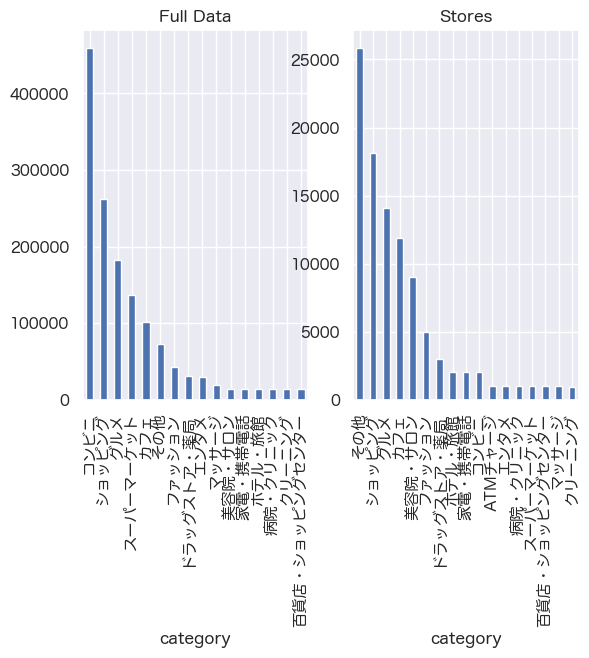

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=2)

full_data_pdf.category.value_counts().plot(kind='bar', ax=axes[0])
axes[0].set_title('Full Data')

stores_pdf.category.value_counts().plot(kind='bar', ax=axes[1])
axes[1].set_title('Stores')


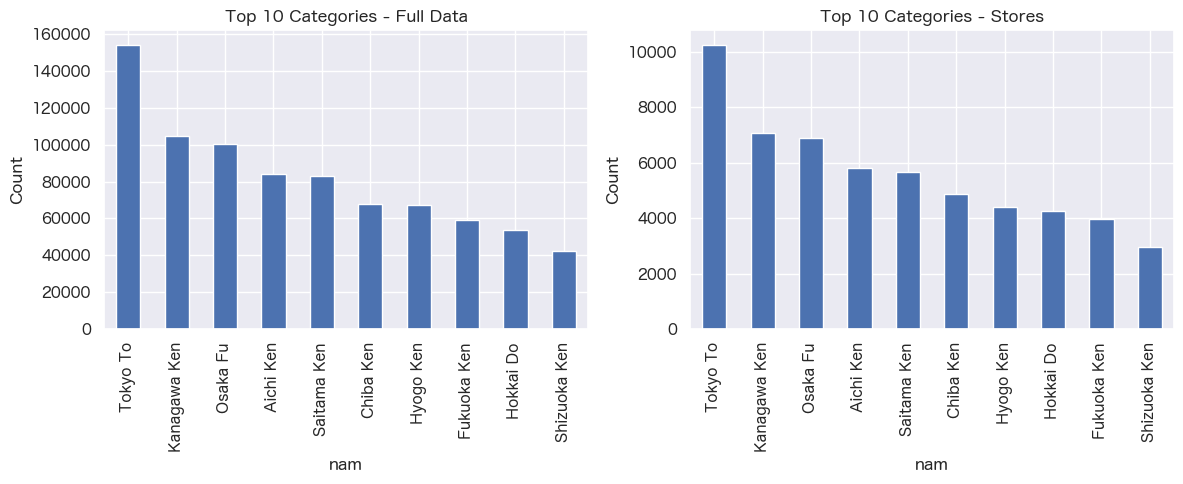

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Plot top 10 categories for 'nam' in the 'full_data_pdf'
full_data_pdf.nam.value_counts().head(10).plot(kind='bar', ax=axes[0])
axes[0].set_title('Top 10 Categories - Full Data')
axes[0].set_ylabel('Count')

# Plot top 10 categories for 'nam' in the 'stores_pdf'
stores_pdf.nam.value_counts().head(10).plot(kind='bar', ax=axes[1])
axes[1].set_title('Top 10 Categories - Stores')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

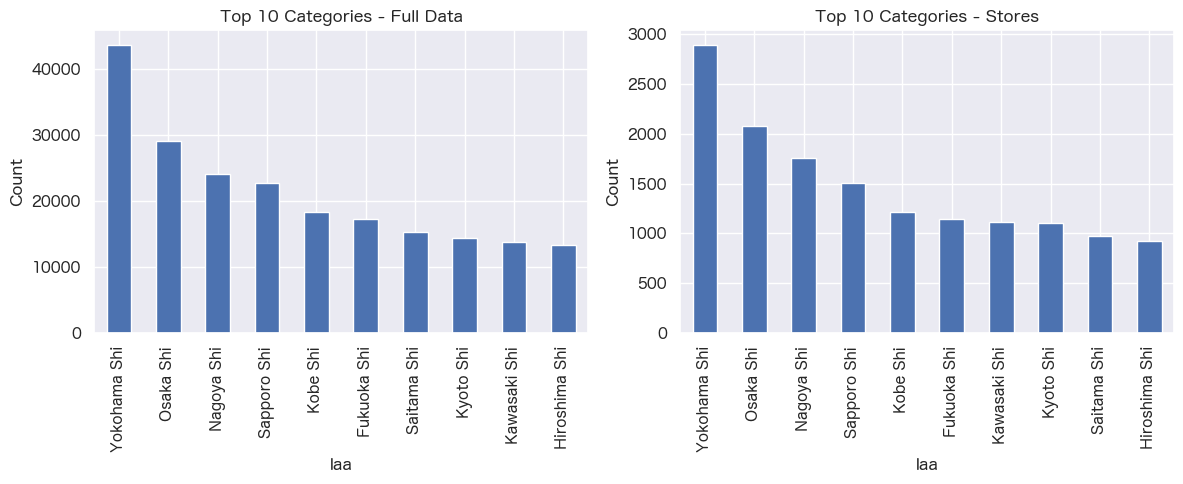

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Plot top 10 categories for 'laa' in the 'full_data_pdf'
full_data_pdf.laa.value_counts().head(10).plot(kind='bar', ax=axes[0])
axes[0].set_title('Top 10 Categories - Full Data')
axes[0].set_ylabel('Count')

# Plot top 10 categories for 'laa' in the 'stores_pdf'
stores_pdf.laa.value_counts().head(10).plot(kind='bar', ax=axes[1])
axes[1].set_title('Top 10 Categories - Stores')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

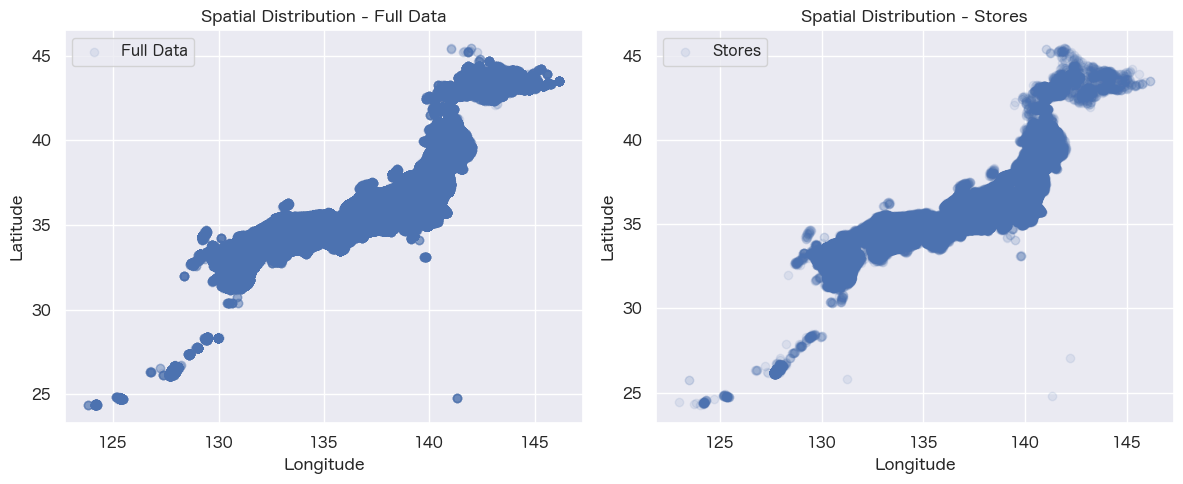

In [15]:
# Create scatter plot for 'full_data_pdf'
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(full_data_pdf['lon'], full_data_pdf['lat'], alpha=0.1, marker='o', label='Full Data')
plt.title('Spatial Distribution - Full Data')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()

# Create scatter plot for 'stores_pdf'
plt.subplot(1, 2, 2)
plt.scatter(stores_pdf['lon'], stores_pdf['lat'], alpha=0.1, marker='o', label='Stores')
plt.title('Spatial Distribution - Stores')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()

plt.tight_layout()
plt.show()


### Temporal Effects
- Summary: To simplify, we analyze temporal effects by categorizing them into `is_weekend`, `month`, and `season`. The significance of each can be observed in the following panels.
- Note: While a time series-like (ARIMA or RNN/LSTM) model could address the problem more comprehensively, it might be computationally intensive for code challenges.

In [16]:
# Assuming 'event_occurrence' is the column representing the date in your dataframe
full_data_pdf['event_occurrence'] = pd.to_datetime(full_data_pdf['event_occurrence'])

# Extracting temporal features
full_data_pdf['is_weekend'] = (full_data_pdf['event_occurrence'].dt.weekday >= 5) * 1  # True for weekdays, False for weekends
full_data_pdf['season'] = (full_data_pdf['event_occurrence'].dt.month % 12 + 3) // 3  # Calculating the season based on months
full_data_pdf['month'] = full_data_pdf['event_occurrence'].dt.month

# Displaying the modified dataframe
print(full_data_pdf[['event_occurrence', 'is_weekend', 'season', 'month']])

                  event_occurrence  is_weekend  season  month
0       2020-01-01 06:40:43.323987           0       1      1
1       2020-01-01 07:04:25.968615           0       1      1
2       2020-01-01 07:06:16.164563           0       1      1
3       2020-01-01 07:07:26.029685           0       1      1
4       2020-01-01 07:12:24.448015           0       1      1
...                            ...         ...     ...    ...
1421973 2021-12-31 16:42:04.018285           0       1     12
1421974 2021-12-31 16:48:25.112299           0       1     12
1421975 2021-12-31 16:54:20.392210           0       1     12
1421976 2021-12-31 17:04:31.609495           0       1     12
1421977 2021-12-31 17:09:49.237044           0       1     12

[1421978 rows x 4 columns]


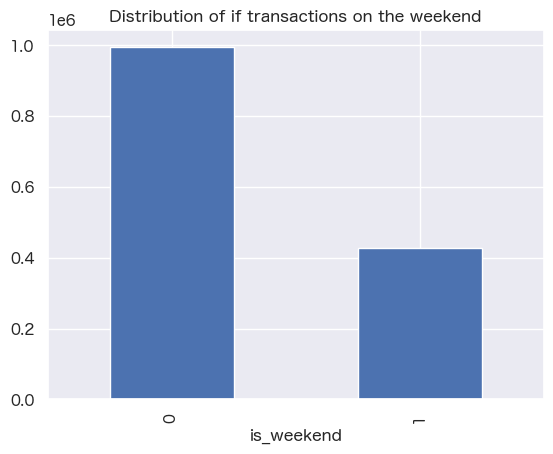

In [17]:
full_data_pdf.is_weekend.value_counts().plot(kind='bar')
plt.title('Distribution of if transactions on the weekend')
plt.show()


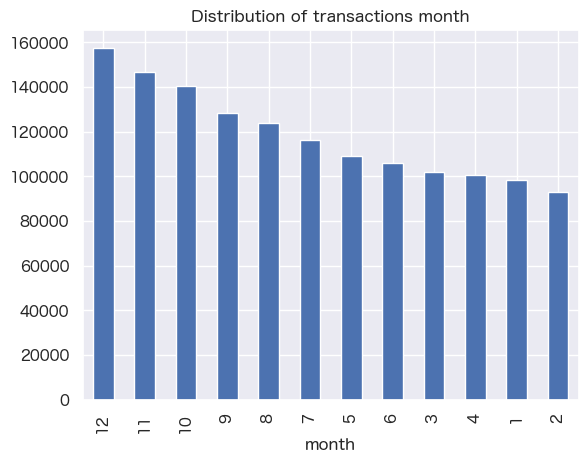

In [18]:
full_data_pdf.month.value_counts().plot(kind='bar')
plt.title('Distribution of transactions month')
plt.show()


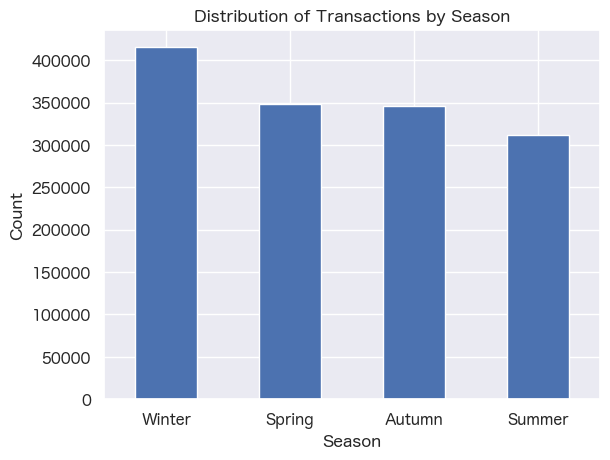

In [19]:
# Assuming full_data_pdf.season contains numeric values representing seasons
# Create a mapping from numeric values to custom labels
season_labels = {1: 'Spring', 2: 'Summer', 3: 'Autumn', 4: 'Winter'}

# Map the numeric values to custom labels
full_data_pdf['season_labels'] = full_data_pdf['season'].map(season_labels)

# Plotting the distribution with custom labels
full_data_pdf['season_labels'].value_counts().plot(kind='bar')
plt.title('Distribution of Transactions by Season')
plt.xlabel('Season')
plt.ylabel('Count')

# Display the custom labels on the x-axis
plt.xticks(rotation=0)  # Set rotation based on your preference
plt.show()


### Spatial Visualization
- Summary: Noteworthy regions with elevated GMV are highlighted, emphasizing the significance of specific locations.

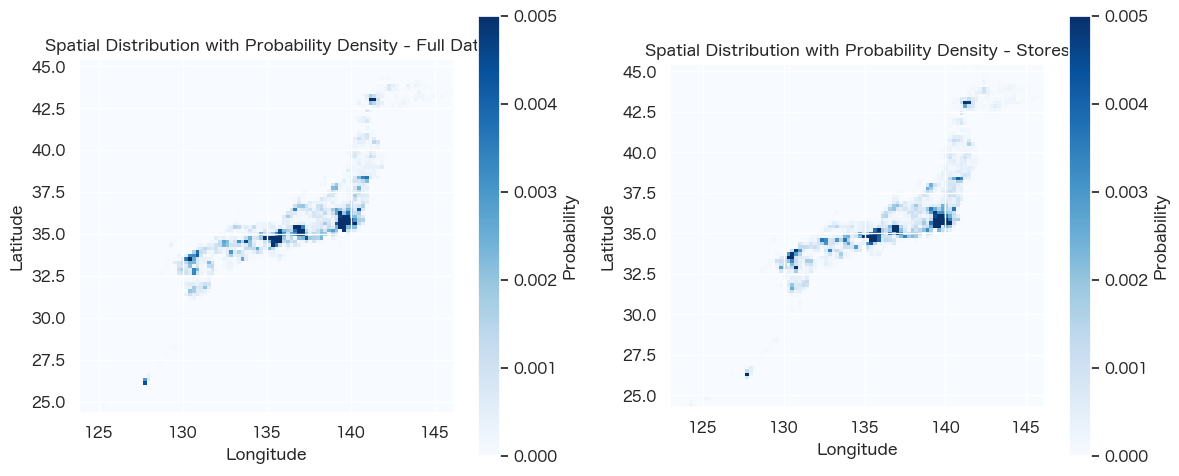

In [20]:
# Assuming 'density' is the column representing the density in your dataframes
counts_full, xedges_full, yedges_full = np.histogram2d(full_data_pdf['lon'], full_data_pdf['lat'], bins=100)
full_probability_density = counts_full / np.sum(counts_full)

counts_stores, xedges_stores, yedges_stores = np.histogram2d(stores_pdf['lon'], stores_pdf['lat'], bins=100)
stores_probability_density = counts_stores / np.sum(counts_stores)

plt.figure(figsize=(12, 5))

# Plot for full_data_pdf
plt.subplot(1, 2, 1)
plt.imshow(full_probability_density.T, extent=(xedges_full.min(), xedges_full.max(), yedges_full.min(), yedges_full.max()), vmax=0.005, cmap='Blues', origin='lower')
plt.colorbar(label='Probability')
plt.title('Spatial Distribution with Probability Density - Full Data')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Plot for stores_pdf
plt.subplot(1, 2, 2)
plt.imshow(stores_probability_density.T, extent=(xedges_stores.min(), xedges_stores.max(), yedges_stores.min(), yedges_stores.max()), vmax=0.005, cmap='Blues', origin='lower')
plt.colorbar(label='Probability')
plt.title('Spatial Distribution with Probability Density - Stores')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.tight_layout()
plt.show()

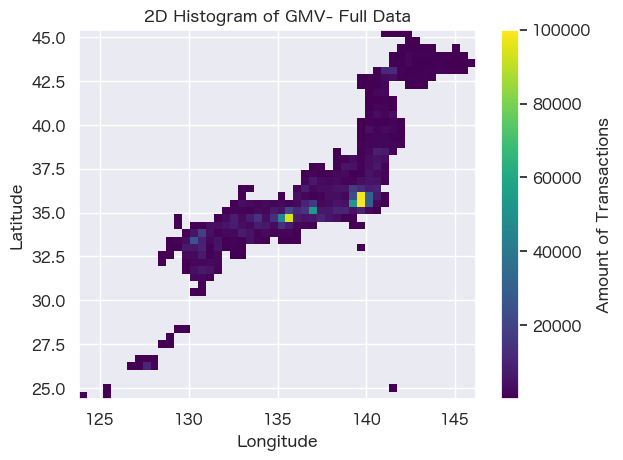

In [21]:
plt.hist2d(full_data_pdf['lon'], full_data_pdf['lat'], bins=(50, 50), cmap='viridis', cmin=1,vmax=100000)
plt.colorbar(label='Amount of Transactions')
plt.title('2D Histogram of GMV- Full Data')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

### Final Features
- Target_col = "amount"

- Sparse_cols = ["gender", "nam", "laa", "category", "is_weekend"]
- Dense_cols = ["age", "lat", "lon", "month", "season"]